# Estimación de dirección de arribo de fuentes sonoras

El objetivo del trabajo es diseñar un sistema de estimación de dirección de arribo de funetes sonoras a través de arrays de micrófonos.

## Situación inicial:

Nos encontramos en campo libre y a una distancia de la fuente de manera que la longitud de onda se considera plana. El sistema consiste en 2 micrófonos de medición de campo libre, esto es respuesta plana en frecuencia y patrón polar omnidireccional, separados por una distancia $d$ de 10 cm. La estimación de dirección se calculará a partir de la diferencia de tiempo de arrivo entre los micrófonos, en donde la diferencia de tiempo de arrivo será obtenida a través de la correlación cruzada entre la señal de ambos micrófonos:

$$
R_{xy}[k] = \sum_{n=0}^{N-1} x[n] \cdot y[n + k]
$$

$$
\tau_{1,2} = \frac{d\cdot cos(\theta)}{c}
$$

$$
\theta = arcos(\frac{c\cdot \tau_{1,2}}{d})
$$


## Pruebas de CC y GCC en señales sinteticas

In [1]:
import numpy as np
import plot
import audio_functions as af
from scipy.signal import correlate
import pyroomacoustics as pra
import IPython

Parametros generales:

In [2]:
c = 343    
fs=48000
duration = 0.1      # duracion de la señal

t = np.linspace(0, duration, int(fs * duration))

Ajustes de cantidad de microfonos y distancia entre ellos:

In [3]:
n_mics = 4
d = 0.1     # distancia entre micrófonos 

Ángulo de la señal que voy a generar artificialmente:

In [4]:
# Genero señales con retardos simulados para un ángulo de llegada dado
theta_deg = 60
theta = np.deg2rad(theta_deg)

Genero señales artificiales. Un pulso en t/2 y un pulso con un piso de ruido propio.
Ademas busco el delay de llegada entre microfonos a partir de la distancia y trigonometria. 
   
Señal A = Pulso unitario  
Señal B = Pulso unitario + Ruido rosa

In [5]:
sample_delays = []

for i in range(n_mics):
    d_i = i * d                            # Distancia del micrófono i al micrófono de referencia (mic_0)
    delay_seg = (d_i * np.cos(theta)) / c  # Retardo en segundos 
    delay_samples = int(delay_seg * fs)          
    sample_delays.append(delay_samples)

# Genero señales 
pulse = np.zeros_like(t)
pulse[int(len(t)/2)] = 1.0

mic_signals = []

for delay in sample_delays:
    señal_retardada = np.roll(pulse, delay)  # Desplaza la señal 'pulse' en el tiempo simulando el retardo
    mic_signals.append(señal_retardada)      # Guarda la señal simulada en la lista

# Genero señales con ruido e IR sintética
mic_signals_rir = af.apply_noise(mic_signals, fs=fs, duration=duration, A_noise = 0.1) 

# Parametros:
# Para ruido y Rir : Rir_A=0.3 y p_noise = 0.05, valores de prueba para ambiente con ruido alto
# Para ruido : rir_A = 0.1, p_noise = 0.07


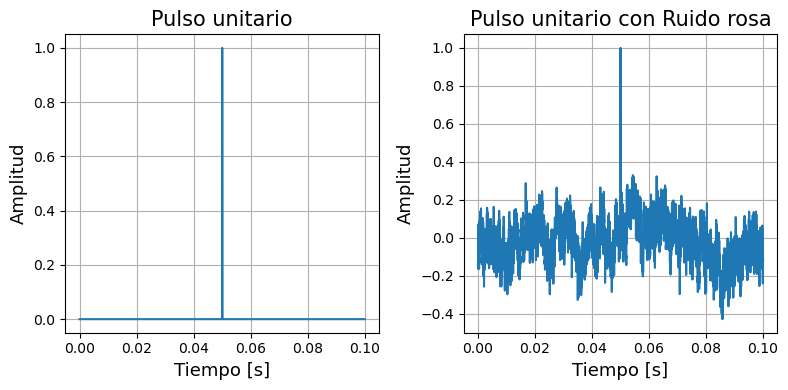

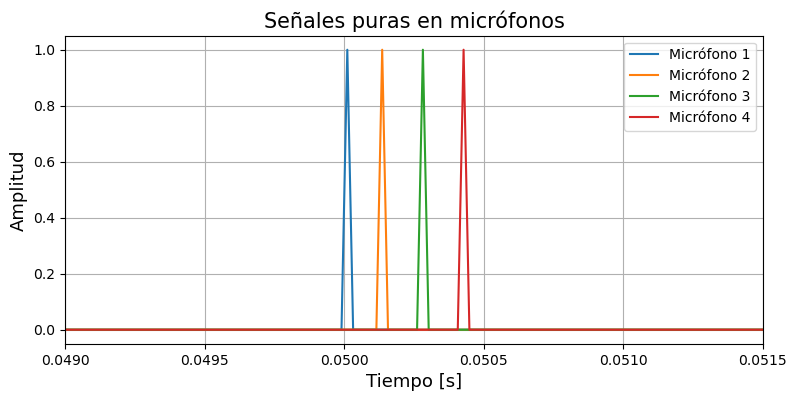

In [6]:
# Grafico señal limpia y con ruido
mic_pulse = lambda: plot.plot_signal({"time vector": t, "signal": mic_signals[0]}, title = "Pulso unitario", show=False, grid = True)
mic_pulse_rir = lambda: plot.plot_signal({"time vector": t, "signal": mic_signals_rir[0]}, title = "Pulso unitario con Ruido rosa", show=False, grid = True)

plot.multiplot(mic_pulse, mic_pulse_rir, figsize=(8, 4))

# Grafico todas las señales
plot_dicts = []

# Armo un diccionario de cada uno para plotear
for i, signal in enumerate(mic_signals):
    color = f"C{i}"  
    dic = {
        "time vector": t,
        "signal": signal,
        "label": f"Micrófono {i+1}",
        "color": color
    }
    plot_dicts.append(dic)

# Plot 
plot.plot_signal(*plot_dicts, title=f"Señales puras en micrófonos", 
                 grid=True, legend=True, figsize=(9, 4), xlimits=(0.049, 0.0515))

## Cálculos y Resultados

### Señal A - Pulso unitario

Realizo cálculos con las señales obtenidas. Primero con la señal limpia busco la Correlación cruzada clásica (CC).

Obtengo una lista de taus y de angulos theta por cada microfono excepto del de referencia.  
De los ángulos obtenidos calculo el promedio y obtengo el ángulo final estimado.

In [7]:
# Calculo los TDOA respecto al primer micrófono 
tau_list_CC = af.get_taus_n_mic(mic_signals, fs, mode= "Classic") 

# Calculo los diferentes angulos respecto a los tau anteriores
est_theta_list_CC = af.get_direction_n_signals(d,tau_list_CC, c, fs)

# Calculo el angulo promedio estimado
theta_prom_CC = (np.sum(est_theta_list_CC[1:])) / (len(est_theta_list_CC ) - 1)     # Promedio (no considero el inicial de referencia)

Resultados de la Señal A, Correlación cruzada clásica:

In [8]:
# Muestro los resultados------------------------------------------------
for i, (tau, est_theta) in enumerate(zip(tau_list_CC, est_theta_list_CC)):            # Mic 1 con valores nulos porque no hay TDOA para comparar 
    print(f"Mic {i+1}: TDOA = {tau:.6f} s, Ángulo estimado = {est_theta:.2f}°")

print(f"El ángulo promedio es: {theta_prom_CC:.2f}°")

Mic 1: TDOA = 0.000000 s, Ángulo estimado = 0.00°
Mic 2: TDOA = 0.000104 s, Ángulo estimado = 69.07°
Mic 3: TDOA = 0.000250 s, Ángulo estimado = 64.61°
Mic 4: TDOA = 0.000396 s, Ángulo estimado = 63.09°
El ángulo promedio es: 65.59°


### Señal B - Pulso unitario con IR + Ruido

#### Señal B - Correlacion cruzada clásica

Con la señal B, busco también el TDOA a partir de la CC.  
Muestro resultados de la señal asociada con el ruido rosa, Correlación cruzada clásica.

In [9]:
# Calculo los TDOA respecto al primer micrófono 
tau_list_CC_B = af.get_taus_n_mic(mic_signals_rir, fs, mode= "Classic") 

# Calculo los diferentes angulos respecto a los tau anteriores
est_theta_list_CC_B = af.get_direction_n_signals(d,tau_list_CC_B, c, fs)

# Calculo el angulo promedio estimado
theta_prom_CC_B = (np.sum(est_theta_list_CC_B[1:])) / (len(est_theta_list_CC_B ) - 1)     # Promedio (no considero el inicial de referencia)

# Muestro los resultados------------------------------------------------
for i, (tau, est_theta) in enumerate(zip(tau_list_CC_B, est_theta_list_CC_B)):            # Mic 1 con valores nulos porque no hay TDOA para comparar 
    print(f"Mic {i+1}: TDOA = {tau:.6f} s, Ángulo estimado = {est_theta:.2f}°")

print(f"El ángulo promedio es: {theta_prom_CC_B:.2f}°")

Mic 1: TDOA = 0.000000 s, Ángulo estimado = 0.00°
Mic 2: TDOA = -0.012792 s, Ángulo estimado = nan°
Mic 3: TDOA = 0.009104 s, Ángulo estimado = nan°
Mic 4: TDOA = -0.014542 s, Ángulo estimado = nan°
El ángulo promedio es: nan°


c:\Users\Blakz\Blakzus\UNTREF\DSP\TP\DSP-TP\audio_functions.py:124: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(c*t/d)


#### Señal B - PHAT

In [10]:
# Calculo los TDOA respecto al primer micrófono 
tau_list_CC_B = af.get_taus_n_mic(mic_signals_rir, fs, mode= "PHAT") 

# Calculo los diferentes angulos respecto a los tau anteriores
est_theta_list_CC_B = af.get_direction_n_signals(d,tau_list_CC_B, c, fs)

# Calculo el angulo promedio estimado
theta_prom_CC_B = (np.sum(est_theta_list_CC_B[1:])) / (len(est_theta_list_CC_B ) - 1)     # Promedio (no considero el inicial de referencia)

# Muestro los resultados------------------------------------------------
for i, (tau, est_theta) in enumerate(zip(tau_list_CC_B, est_theta_list_CC_B)):            # Mic 1 con valores nulos porque no hay TDOA para comparar 
    print(f"Mic {i+1}: TDOA = {tau:.6f} s, Ángulo estimado = {est_theta:.2f}°")

print(f"El ángulo promedio es: {theta_prom_CC_B:.2f}°")

Mic 1: TDOA = 0.000000 s, Ángulo estimado = 0.00°
Mic 2: TDOA = 0.000104 s, Ángulo estimado = 69.07°
Mic 3: TDOA = 0.000250 s, Ángulo estimado = 64.61°
Mic 4: TDOA = 0.000396 s, Ángulo estimado = 63.09°
El ángulo promedio es: 65.59°


### Señal B - SCOT

In [11]:
# Calculo los TDOA respecto al primer micrófono 
tau_list_CC_B = af.get_taus_n_mic(mic_signals_rir, fs, mode= "SCOT") 

# Calculo los diferentes angulos respecto a los tau anteriores
est_theta_list_CC_B = af.get_direction_n_signals(d,tau_list_CC_B, c, fs)

# Calculo el angulo promedio estimado
theta_prom_CC_B = (np.sum(est_theta_list_CC_B[1:])) / (len(est_theta_list_CC_B ) - 1)     # Promedio (no considero el inicial de referencia)

# Muestro los resultados------------------------------------------------
for i, (tau, est_theta) in enumerate(zip(tau_list_CC_B, est_theta_list_CC_B)):            # Mic 1 con valores nulos porque no hay TDOA para comparar 
    print(f"Mic {i+1}: TDOA = {tau:.6f} s, Ángulo estimado = {est_theta:.2f}°")

print(f"El ángulo promedio es: {theta_prom_CC_B:.2f}°")

Mic 1: TDOA = 0.000000 s, Ángulo estimado = 0.00°
Mic 2: TDOA = 0.000104 s, Ángulo estimado = 69.07°
Mic 3: TDOA = 0.000250 s, Ángulo estimado = 64.61°
Mic 4: TDOA = 0.000396 s, Ángulo estimado = 63.09°
El ángulo promedio es: 65.59°


### Señal B - ROTH

In [12]:
# Calculo los TDOA respecto al primer micrófono 
tau_list_CC_B = af.get_taus_n_mic(mic_signals_rir, fs, mode= "ROTH") 

# Calculo los diferentes angulos respecto a los tau anteriores
est_theta_list_CC_B = af.get_direction_n_signals(d,tau_list_CC_B, c, fs)

# Calculo el angulo promedio estimado
theta_prom_CC_B = (np.sum(est_theta_list_CC_B[1:])) / (len(est_theta_list_CC_B ) - 1)     # Promedio (no considero el inicial de referencia)

# Muestro los resultados------------------------------------------------
for i, (tau, est_theta) in enumerate(zip(tau_list_CC_B, est_theta_list_CC_B)):            # Mic 1 con valores nulos porque no hay TDOA para comparar 
    print(f"Mic {i+1}: TDOA = {tau:.6f} s, Ángulo estimado = {est_theta:.2f}°")

print(f"El ángulo promedio es: {theta_prom_CC_B:.2f}°")

Mic 1: TDOA = 0.000000 s, Ángulo estimado = 0.00°
Mic 2: TDOA = -0.046458 s, Ángulo estimado = nan°
Mic 3: TDOA = -0.004083 s, Ángulo estimado = nan°
Mic 4: TDOA = -0.011583 s, Ángulo estimado = nan°
El ángulo promedio es: nan°


## Pruebas en campo libre

#### Cargamos una habitación anecocia para simular campo libre y agregamos la ubicación de la fuente y los micrófonos.

In [13]:
fs = 48000

#Creo la habitación anecoica
room = pra.AnechoicRoom(dim=3, fs=fs, air_absorption=True, temperature=20, humidity=40)

#Cargo el audio para poder asignarlo a la fuente
audio, _ =af.load_audio("audios_anecoicos/p336_001.wav")

#Agrego fuente a la sala
room.add_source([0, 5, 2], signal=audio)

#Agrego array de mics a la sala
mic_array_loc = np.c_[[20, 0, 1.2], [20, 0.1, 1.2], [20, 0.2, 1.2], [20, 0.3, 1.2]]
room.add_microphone_array(mic_array_loc)

room.plot(mic_marker_size=30, source_marker_size=30)
af.play_audio(audio,fs)

#### Realizamos la simulación y obtenemos los audios por cada receptor ubicado.

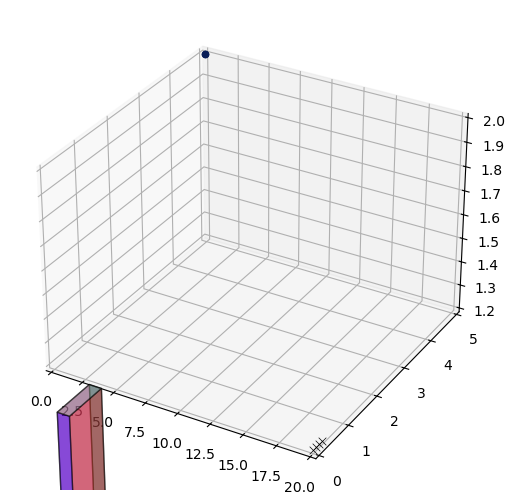

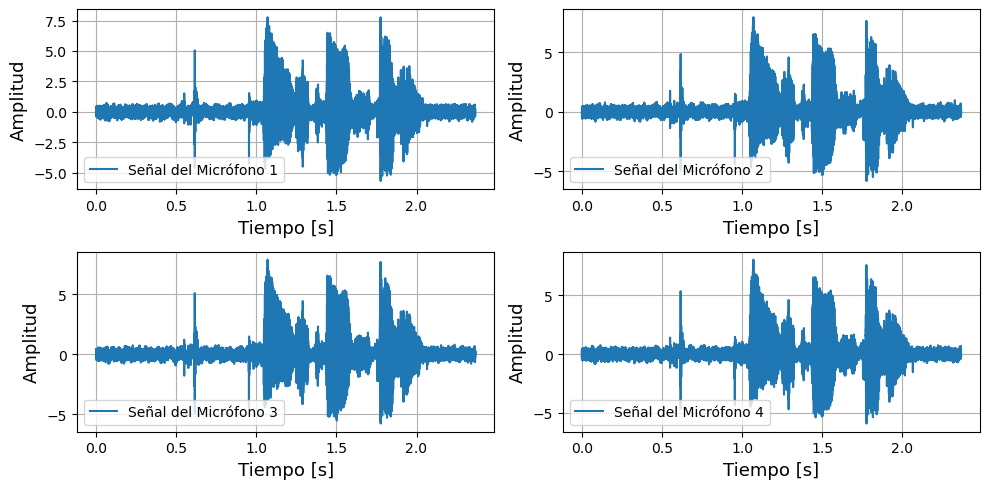

In [14]:
#Realizo la simulación
room.simulate(snr = 15)
plots=[]
#Obtengo cada audio grabado en la sala
grabaciones = room.mic_array.signals
for i in np.arange(len(grabaciones)):
    mic_i = grabaciones[i]
    dur, t = af.get_audio_time_array(mic_i, fs)
    label = f"Señal del Micrófono {i+1}"
    mic_plot = lambda mic=mic_i, tiempo=t, etiqueta=label: plot.plot_signal(
        {"time vector": tiempo, "signal": mic, "label": etiqueta},
        legend=True, grid=True, show=False)
  
    plots.append(mic_plot)
    af.play_audio(mic_i, fs)
plot.multiplot(plots[0], plots[1], plots[2], plots[3], figsize=(10, 5), ncols=2)

### Pruebas de CC y GCC en campo libre

#### En primer lugar realizamos la correlación cruzada clásica a partir de la librería Scipy para tener de referencia.

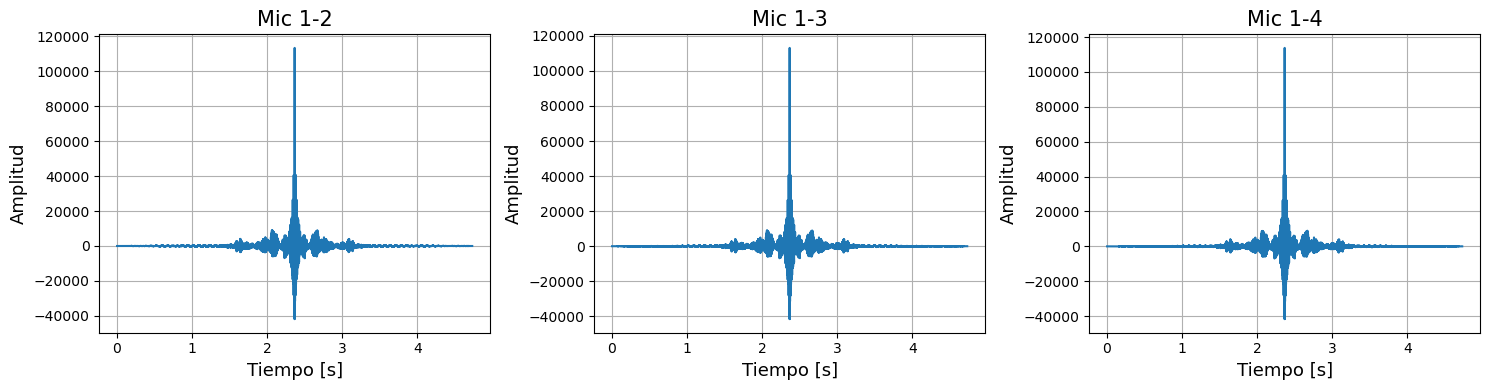

In [15]:
corr = []
for i in np.arange(len(grabaciones)-1):
    corr_class = correlate(grabaciones[0], grabaciones[i+1])
    corr.append(corr_class)

_, t_corr = af.get_audio_time_array(corr[0], fs)

corr_1_pd = lambda: plot.plot_signal({"time vector":t_corr, "signal":corr[0]}, title="Mic 1-2", grid=True, show=False)
corr_2_pd = lambda: plot.plot_signal({"time vector":t_corr, "signal":corr[1]}, title="Mic 1-3", grid=True, show=False)
corr_3_pd = lambda: plot.plot_signal({"time vector":t_corr, "signal":corr[2]}, title="Mic 1-4", grid=True, show=False)

plot.multiplot(corr_1_pd, corr_2_pd, corr_3_pd, figsize=(15, 4), ncols=3)

#### Realizamos la correlación cruzada clásica y generalizada para los diferentes receptores, a partir del algoritmo anteriormente generado. 

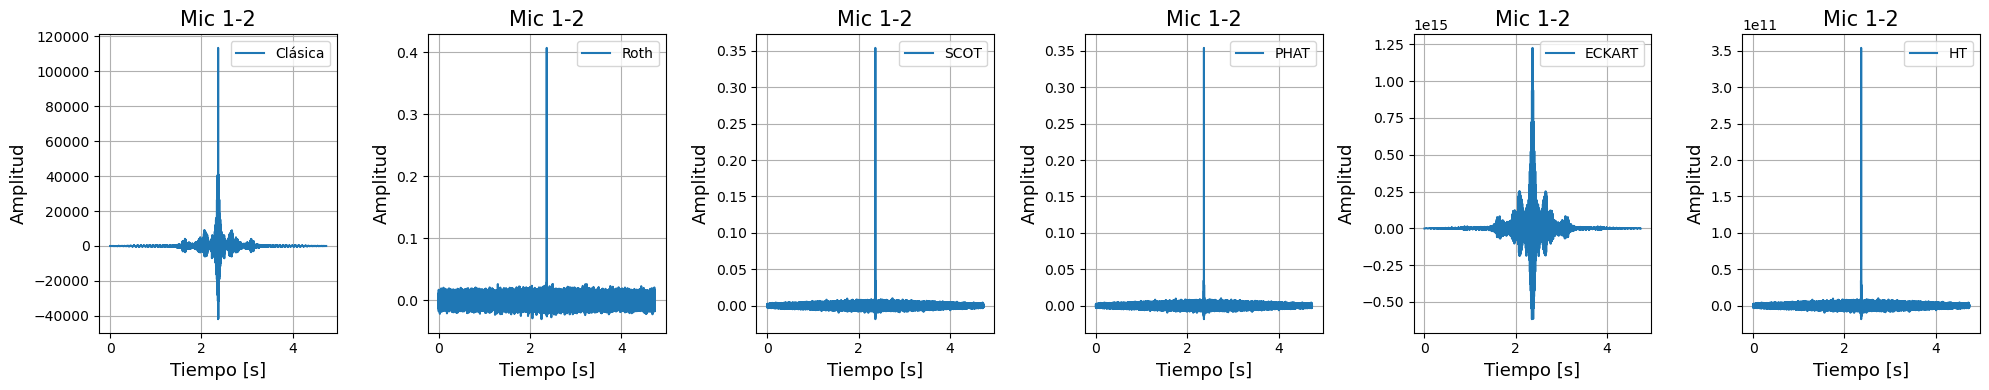

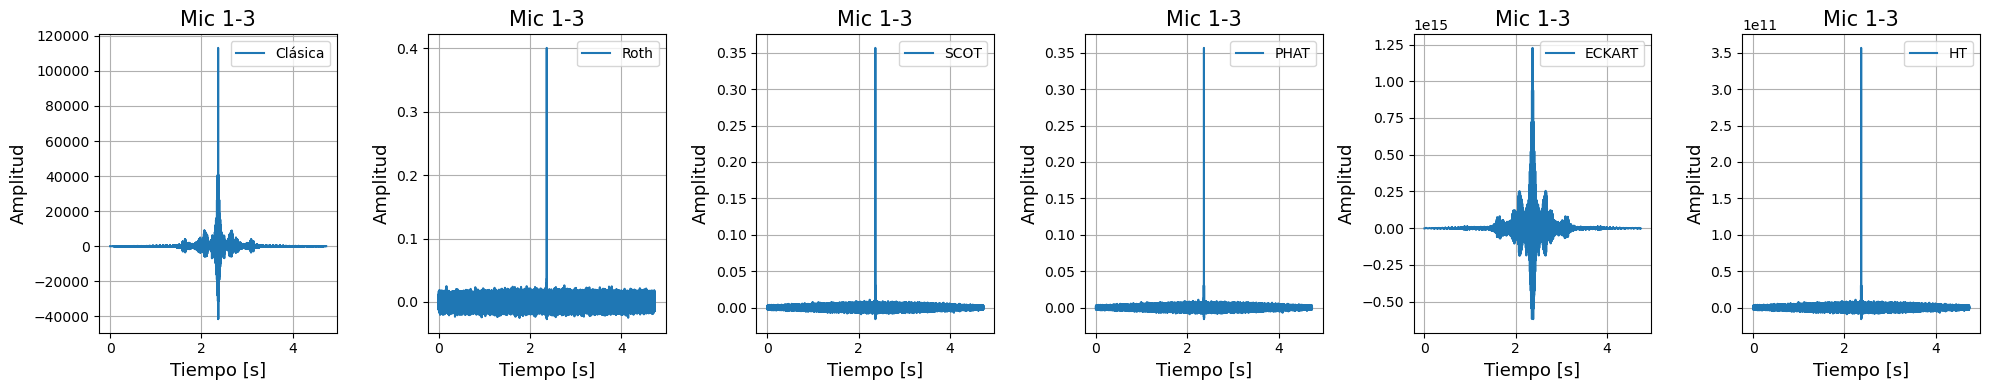

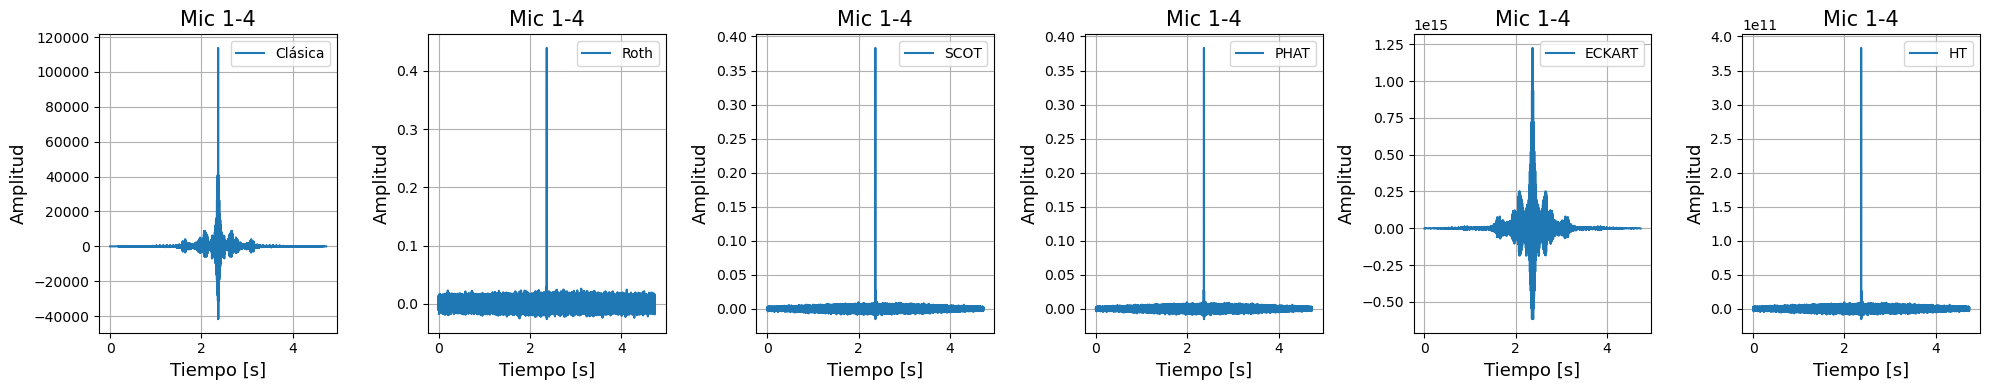

In [16]:
for i in np.arange(len(grabaciones)-1):
    
    corr_class = af.cross_corr(grabaciones[0], grabaciones[i+1], fs=fs)
    corr_roth = af.cross_corr(grabaciones[0], grabaciones[i+1], fs=fs, mode="ROTH")
    corr_scot = af.cross_corr(grabaciones[0], grabaciones[i+1], fs=fs, mode="SCOT")
    corr_phat = af.cross_corr(grabaciones[0], grabaciones[i+1], fs=fs, mode="PHAT")
    corr_eckart = af.cross_corr(grabaciones[0], grabaciones[i+1], fs=fs, mode="ECKART")
    corr_HT = af.cross_corr(grabaciones[0], grabaciones[i+1], fs=fs, mode="HT")
    _, t_corr = af.get_audio_time_array(corr_class, fs)
    corr_class_pd = lambda: plot.plot_signal({"time vector":t_corr, "signal":corr_class, "label":"Clásica"}, legend=True, title=f"Mic 1-{i+2}", grid=True, show=False)
    corr_roth_pd = lambda: plot.plot_signal({"time vector":t_corr, "signal":corr_roth, "label":"Roth"}, legend=True, title=f"Mic 1-{i+2}", grid=True, show=False)
    corr_scot_pd = lambda: plot.plot_signal({"time vector":t_corr, "signal":corr_scot, "label":"SCOT"}, legend=True, title=f"Mic 1-{i+2}", grid=True, show=False)
    corr_phat_pd = lambda: plot.plot_signal({"time vector":t_corr, "signal":corr_phat, "label":"PHAT"}, legend=True, title=f"Mic 1-{i+2}", grid=True, show=False)
    corr_eckart_pd = lambda: plot.plot_signal({"time vector":t_corr, "signal":corr_eckart, "label":"ECKART"}, legend=True, title=f"Mic 1-{i+2}", grid=True, show=False)
    corr_HT_pd = lambda: plot.plot_signal({"time vector":t_corr, "signal":corr_HT, "label":"HT"}, legend=True, title=f"Mic 1-{i+2}", grid=True, show=False)

    plot.multiplot(corr_class_pd, corr_roth_pd, corr_scot_pd, corr_phat_pd, corr_eckart_pd, corr_HT_pd,figsize=(20, 4), ncols=6)
    

## Pruebas en campo difuso

#### Cargamos una habitación con las dimensiones especificadas para trabajar en campo reverberante, y agregamos la ubicación de la fuente y los micrófonos.
#### Además, cargamos el audio anecoico para tener una primera escucha.

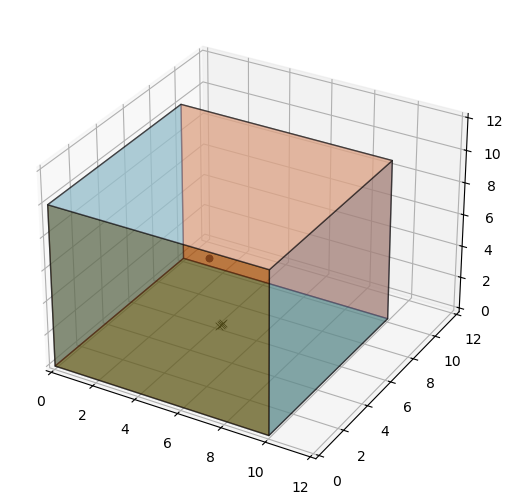

In [17]:
#Determino coeficiente de absorción 0 para simular campo reverberante y lo convierto en un material
abs_prom = pra.Material(0.01)

#Determino dimensiones y frecuencia de sampleo, dimensiones muy grandes para campo libre
room_dim = [10, 10, 10]
fs = 48000

#Creo la habitación
room = pra.ShoeBox(room_dim, fs=fs, max_order=100, materials=abs_prom, air_absorption=True, temperature=20, humidity=40)

#Cargo el audio para poder asignarlo a la fuente
audio, _ =af.load_audio("audios_anecoicos/p336_001.wav")

#Agrego fuente a la sala
room.add_source([2, 8.9, 1.5], signal=audio)

#Agrego array de mics a la sala, lejos de superficies para alejarse de campo cercano.
d_mic = 0.1
mic_array_loc = np.c_[[5, 4.7, 1.2], [5, 4.7+d_mic, 1.2], [5, 4.7+(d_mic*2), 1.2], [5, 4.7+(d_mic*3), 1.2]]
room.add_microphone_array(mic_array_loc)

#Grafico el recinto
fig, ax = room.plot(mic_marker_size=30, source_marker_size=30)
plot.plot_room(fig, ax, xlim=room_dim[0]+0.2*room_dim[0], ylim=room_dim[1]+0.2*room_dim[1], zlim=room_dim[2]+0.2*room_dim[2])

af.play_audio(audio,fs)

#### A partir de la sala simulada y la señal de audio anecoica, se generó una auralización individual para cada uno de los receptores del arreglo.

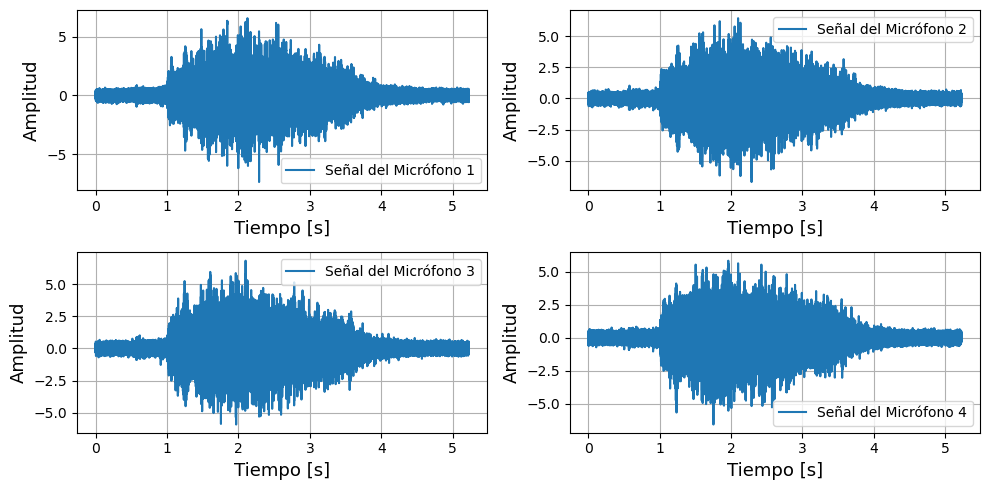

In [18]:
#Realizo la simulación
room.simulate(snr = 15)

#Obtengo cada audio grabado en la sala
grabaciones = room.mic_array.signals
plots = []
for i in np.arange(len(grabaciones)):
    mic_i = grabaciones[i]
    dur, t = af.get_audio_time_array(mic_i, fs)
    label = f"Señal del Micrófono {i+1}"
    mic_plot = lambda mic=mic_i, tiempo=t, etiqueta=label: plot.plot_signal(
        {"time vector": tiempo, "signal": mic, "label": etiqueta},
        legend=True, grid=True, show=False)
    
    plots.append(mic_plot)
    af.play_audio(mic_i, fs)
plot.multiplot(plots[0], plots[1], plots[2], plots[3], figsize=(10, 5), ncols=2)


### Pruebas de CC y GCC en campo difuso

#### En primer lugar realizamos la correlación cruzada clásica a partir de la librería Scipy para tener de referencia.

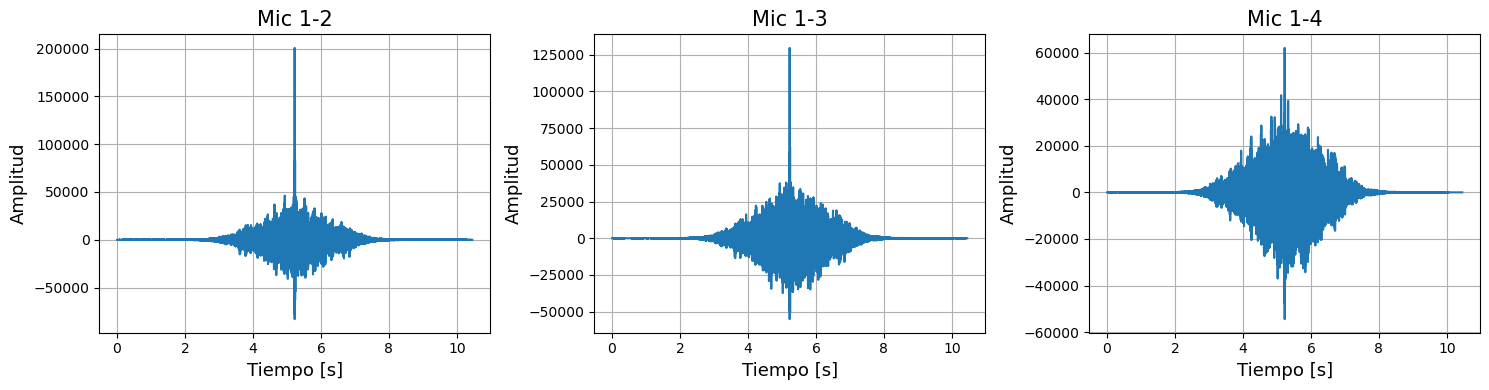

In [19]:
corr = []
for i in np.arange(len(grabaciones)-1):
    corr_class = correlate(grabaciones[0], grabaciones[i+1])
    corr.append(corr_class)

_, t_corr = af.get_audio_time_array(corr[0], fs)

corr_1_pd = lambda: plot.plot_signal({"time vector":t_corr, "signal":corr[0]}, title="Mic 1-2", grid=True, show=False)
corr_2_pd = lambda: plot.plot_signal({"time vector":t_corr, "signal":corr[1]}, title="Mic 1-3", grid=True, show=False)
corr_3_pd = lambda: plot.plot_signal({"time vector":t_corr, "signal":corr[2]}, title="Mic 1-4", grid=True, show=False)

plot.multiplot(corr_1_pd, corr_2_pd, corr_3_pd, figsize=(15, 4), ncols=3)

#### Realizamos la correlación cruzada clásica y generalizada para los diferentes receptores, a partir del algoritmo anteriormente generado. 

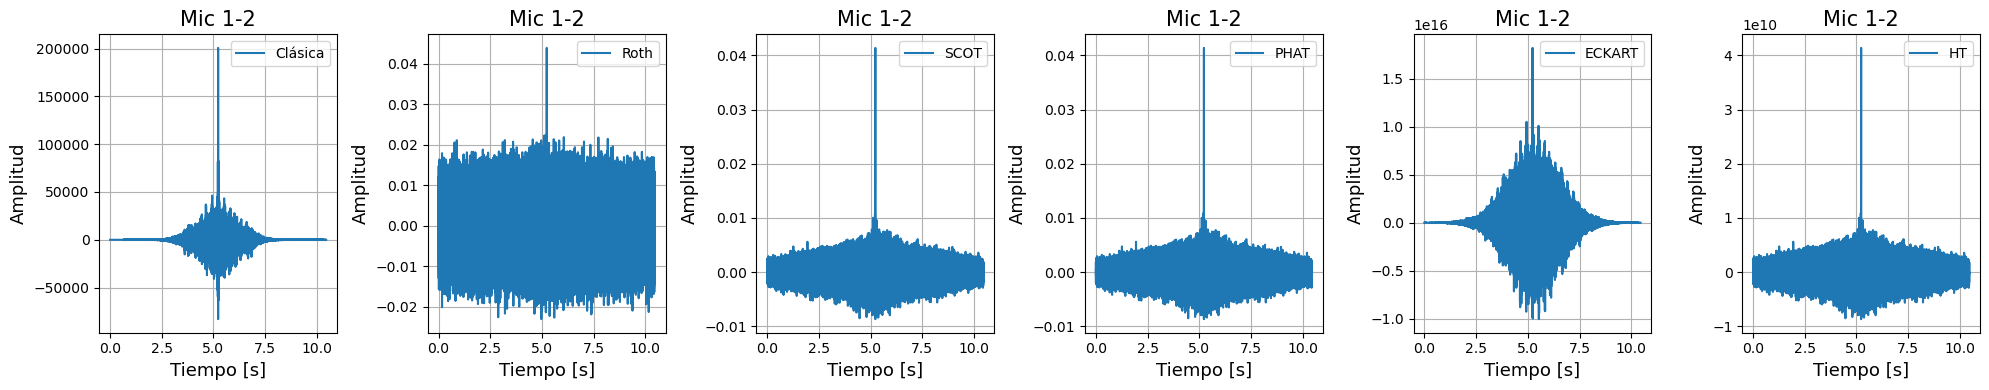

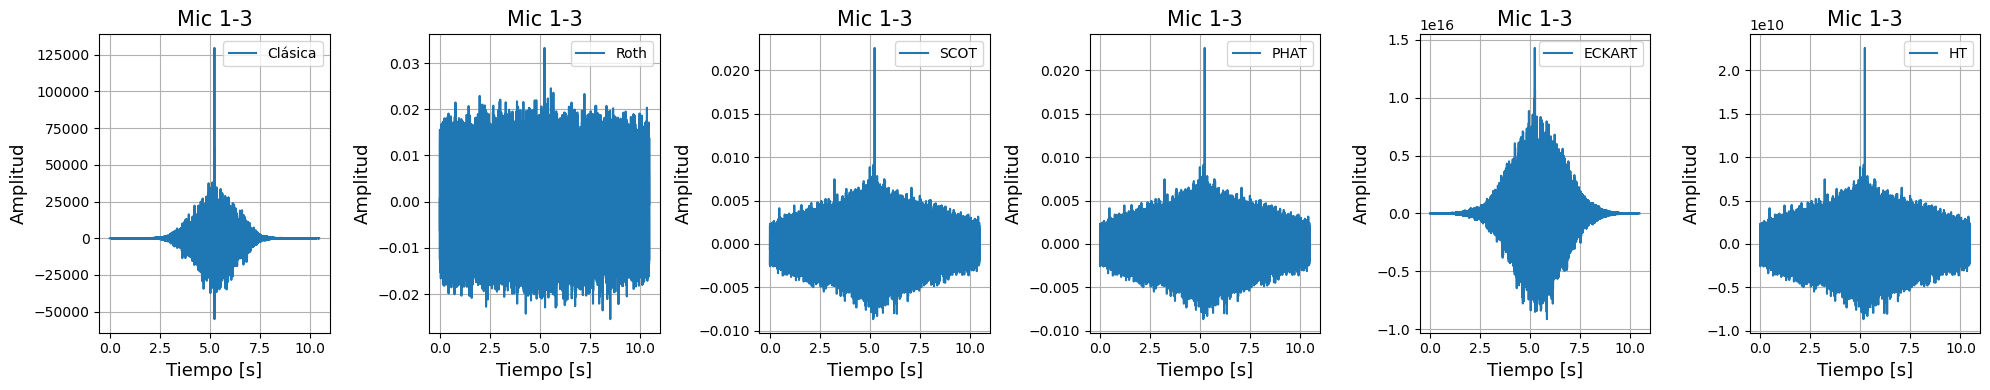

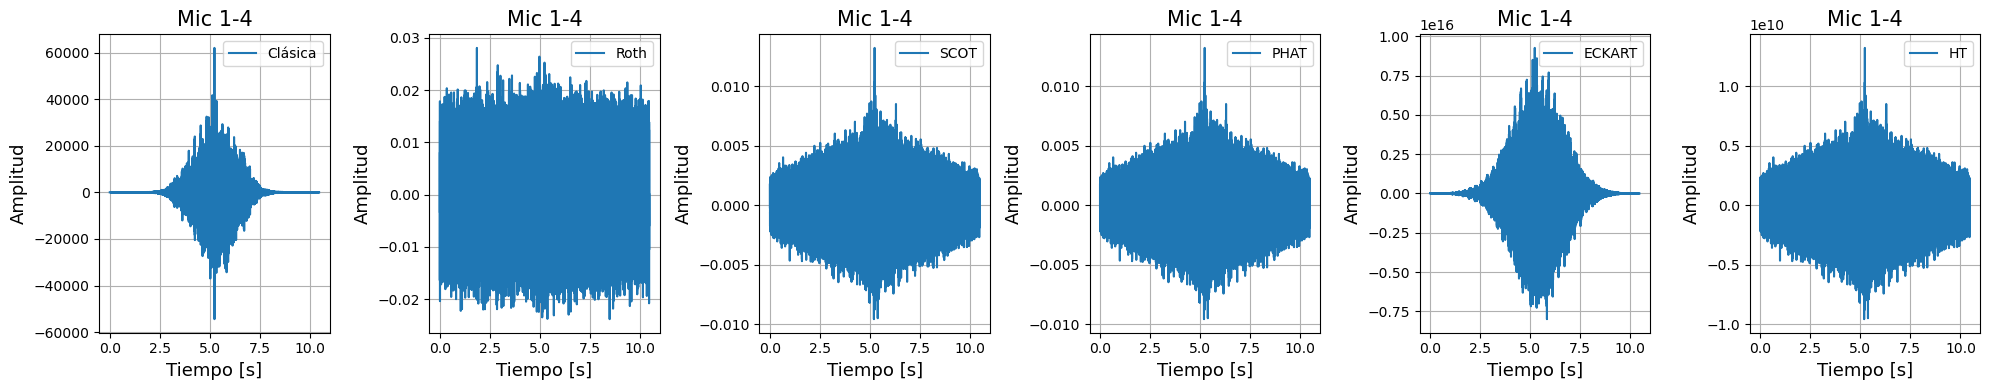

In [20]:
for i in np.arange(len(grabaciones)-1):
    corr_class = af.cross_corr(grabaciones[0], grabaciones[i+1], fs=fs)
    corr_roth = af.cross_corr(grabaciones[0], grabaciones[i+1], fs=fs, mode="ROTH")
    corr_scot = af.cross_corr(grabaciones[0], grabaciones[i+1], fs=fs, mode="SCOT")
    corr_phat = af.cross_corr(grabaciones[0], grabaciones[i+1], fs=fs, mode="PHAT")
    corr_eckart = af.cross_corr(grabaciones[0], grabaciones[i+1], fs=fs, mode="ECKART")
    corr_HT = af.cross_corr(grabaciones[0], grabaciones[i+1], fs=fs, mode="HT")
    _, t_corr = af.get_audio_time_array(corr_class, fs)
    corr_class_pd = lambda: plot.plot_signal({"time vector":t_corr, "signal":corr_class, "label":"Clásica"}, legend=True, title=f"Mic 1-{i+2}", grid=True, show=False)
    corr_roth_pd = lambda: plot.plot_signal({"time vector":t_corr, "signal":corr_roth, "label":"Roth"}, legend=True, title=f"Mic 1-{i+2}", grid=True, show=False)
    corr_scot_pd = lambda: plot.plot_signal({"time vector":t_corr, "signal":corr_scot, "label":"SCOT"}, legend=True, title=f"Mic 1-{i+2}", grid=True, show=False)
    corr_phat_pd = lambda: plot.plot_signal({"time vector":t_corr, "signal":corr_phat, "label":"PHAT"}, legend=True, title=f"Mic 1-{i+2}", grid=True, show=False)
    corr_eckart_pd = lambda: plot.plot_signal({"time vector":t_corr, "signal":corr_eckart, "label":"ECKART"}, legend=True, title=f"Mic 1-{i+2}", grid=True, show=False)
    corr_HT_pd = lambda: plot.plot_signal({"time vector":t_corr, "signal":corr_HT, "label":"HT"}, legend=True, title=f"Mic 1-{i+2}", grid=True, show=False)

    plot.multiplot(corr_class_pd, corr_roth_pd, corr_scot_pd, corr_phat_pd, corr_eckart_pd, corr_HT_pd,figsize=(20, 4), ncols=6)
    